In [1]:
import numpy as np
from numpy import log, sin, cos, arctan2, pi, mean
from numpy.linalg import norm, solve
import matplotlib.pyplot as plt
import meshio
from pyqtree import Index
import matplotlib.pyplot as plt


# Reu Santi

In [53]:
def read_geo_gmsh(fname, dir_groups, neu_groups):
    """Read the geometry from a Gmsh file with physical groups

    Parameters
    ----------
    fname : str
        Path to the mesh file.
    dir_groups : list
        List with the number of the physical groups associated
        with Dirichlet boundary conditions.
    neu_groups : list
        List with the number of the physical groups associated
        with Dirichlet boundary conditions.

    Returns
    -------
    mesh : meshio Mesh object
        Mesh object.
    coords : ndarray, float
        Coordinates for the endpoints of the elements in the
        boundary.
    elems : ndarray, int
        Connectivity for the elements.
    x_m : ndarray, float
        Horizontal component of the midpoint of the elements.
    y_m : ndarray, float
        Vertical component of the midpoint of the elements.
    id_dir : list
        Identifiers for elements with Dirichlet boundary conditions.
    id_neu : list
        Identifiers for elements with Neumann boundary conditions.
    """
    mesh = meshio.read(fname)
    elems_dir = np.vstack([mesh.cells[k].data for k in dir_groups])
    if neu_groups is None:
        elems_neu = np.array([])
        elems = elems_dir.copy()
    else:
        elems_neu = np.vstack([mesh.cells[k].data for k in neu_groups])
        elems = np.vstack((elems_dir, elems_neu))
    bound_nodes = list(set(elems.flatten()))
    coords = mesh.points[bound_nodes, :2]
    x_m, y_m = 0.5*(coords[elems[:, 0]] + coords[elems[:, 1]]).T
    id_dir = range(elems_dir.shape[0])
    id_neu = range(elems_dir.shape[0],
                   elems_dir.shape[0] + elems_neu.shape[0])
    return mesh, coords, elems, x_m, y_m, id_dir, id_neu

def calcular_bbox(coords):
    """
    Calcula el bounding box (bbox) a partir de un arreglo de coordenadas.
    
    :param coordenadas: Lista de tuplas (x, y) representando puntos.
    :return: Tupla (x_min, y_min, x_max, y_max) que define el bounding box.
    """

    
    # Inicializar con los valores del primer punto
    x_min = x_max = coords[0][0]
    y_min = y_max = coords[0][1]
    
    # Iterar sobre el resto de los puntos
    for x, y in coords[1:]:
        x_min = min(x_min, x)
        x_max = max(x_max, x)
        y_min = min(y_min, y)
        y_max = max(y_max, y)

    bbox = (x_min, y_min, x_max, y_max)
    
    return bbox

def crear_quadtree(coords):
    """
    Crea un QuadTree a partir de una lista de puntos.
    
    :param puntos: Lista de tuplas (x, y) representando los puntos de la malla.
    :param bbox: Tupla (x_min, y_min, x_max, y_max) que define el área del QuadTree.
    :return: Un objeto Index de pyqtree (QuadTree).
    """
    # Crear el índice QuadTree
    bbox = calcular_bbox(coords)
    quadtree = Index(bbox,max_items=10, max_depth=20)
    
    # Insertar cada punto en el QuadTree
    for i, (x, y) in enumerate(coords):
        quadtree.insert(item=i, bbox=(x, y, x, y))
    
    return quadtree, bbox

def graficar_quadtree(quadtree, puntos, bbox):
    """
    Grafica un QuadTree junto con los puntos que contiene.
    
    :param quadtree: Objeto Index de pyqtree (QuadTree).
    :param puntos: Lista de tuplas (x, y) representando los puntos originales.
    :param bbox: Tupla (x_min, y_min, x_max, y_max) que define el área del QuadTree.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    
    def dibujar_nodo(bbox, depth=0):
        x1, y1, x2, y2 = bbox
        width = x2 - x1
        height = y2 - y1
        
        # Dibujar el rectángulo del nodo
        rect = plt.Rectangle((x1, y1), width, height, fill=False)
        ax.add_patch(rect)
        
        # Verificar si hay más subdivisiones
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2
        
        # Consultar el quadtree para ver si hay puntos en cada cuadrante
        ne = quadtree.intersect((center_x, center_y, x2, y2))
        nw = quadtree.intersect((x1, center_y, center_x, y2))
        se = quadtree.intersect((center_x, y1, x2, center_y))
        sw = quadtree.intersect((x1, y1, center_x, center_y))
        
        # Si hay puntos y no hemos alcanzado una profundidad máxima, seguir subdividiendo
        max_depth = 10  # Puedes ajustar este valor
        if depth < max_depth:
            if ne: dibujar_nodo((center_x, center_y, x2, y2), depth + 1)
            if nw: dibujar_nodo((x1, center_y, center_x, y2), depth + 1)
            if se: dibujar_nodo((center_x, y1, x2, center_y), depth + 1)
            if sw: dibujar_nodo((x1, y1, center_x, center_y), depth + 1)
    
    # Dibujar la estructura del QuadTree
    dibujar_nodo(bbox)
    
    # Dibujar los puntos
    x, y = zip(*puntos)
    ax.scatter(x, y, c='red', s=20)
    
    # Configurar los límites y etiquetas del gráfico
    ax.set_xlim(bbox[0], bbox[2])
    ax.set_ylim(bbox[1], bbox[3])
    ax.set_aspect('equal')
    ax.set_title('Visualización del QuadTree')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    plt.tight_layout()
    plt.show()

In [54]:
mesh, coords, elems, x_m, y_m, id_dir, id_neu = read_geo_gmsh(r"files\disk.msh", [0, 1], [2, 3])
quadtree, bbox = crear_quadtree(coords)

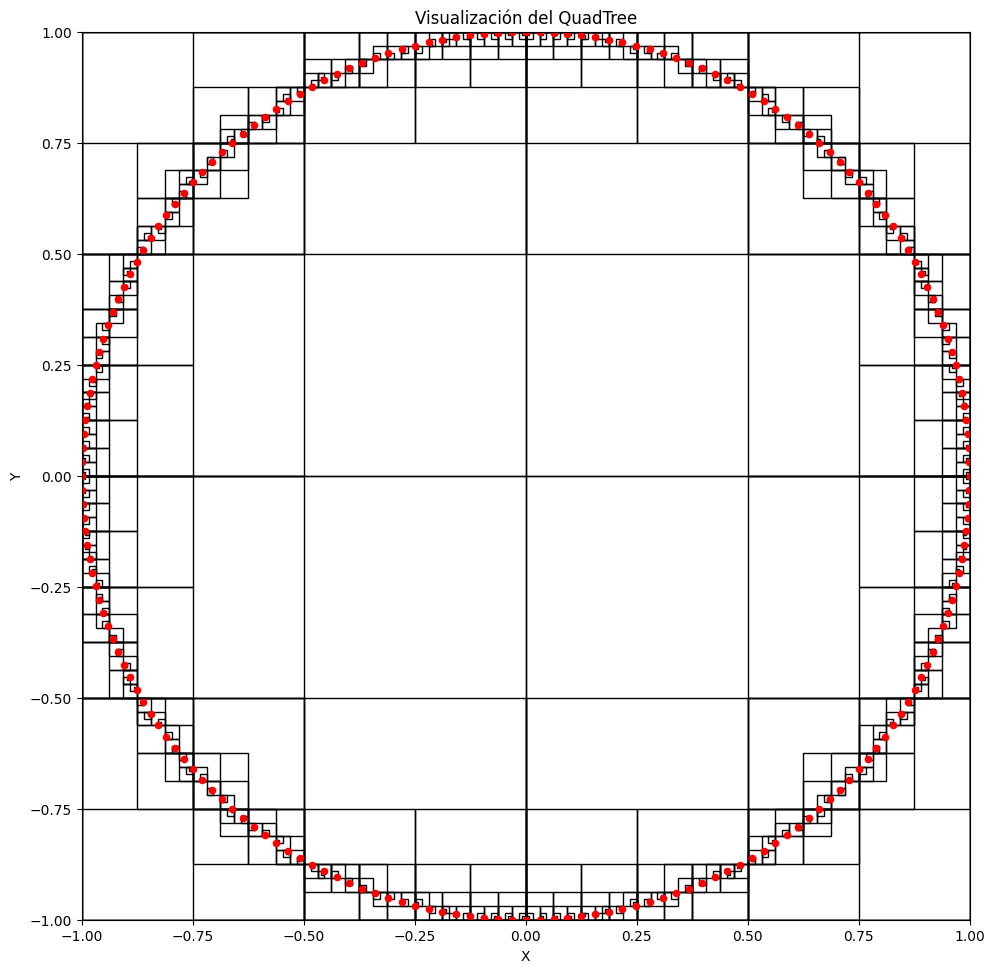

In [4]:
graficar_quadtree(quadtree,coords,bbox)

In [77]:
import numpy as np
from scipy.special import iv as modified_bessel_i  # Función de Bessel modificada I_k

# Función que procesa el quadtree y aplica las interacciones
def procesar_quadtree(quadtree):
    """
    Procesa el quadtree aplicando las interacciones M2M, M2L y L2L.

    Parámetros:
    - quadtree: El nodo raíz del quadtree que se va a procesar.
    """
    # Función recursiva para procesar cada nodo del quadtree
    def traverse_quadtree(node):
        if node.children:  # Si tiene hijos, es una rama
            # Realiza la traducción M2M entre la rama y sus hojas
            M2M_translation(node, node.children)

            # Recorre los hijos del nodo
            for child in node.children:
                traverse_quadtree(child)

                if not child.children:  # Si no tiene hijos, es una hoja
                    # Traducción M2L (Momento a Local) entre rama y hoja
                    M2L_translation(node, child)
                else:
                    # Traducción L2L (Local a Local) entre ramas y hojas
                    L2L_translation(node, node.children)

    # Inicia el procesamiento recursivo desde la raíz del quadtree
    traverse_quadtree(quadtree)

# Implementación de las interacciones utilizando las ecuaciones del paper

def M2M_translation(rama, hojas):
    """
    Traducción de Momento a Momento (M2M) usando la ecuación (21) del paper.
    
    Parámetros:
    - rama: Nodo de la rama (nodo superior en el quadtree).
    - hojas: Lista de nodos hoja (nodos hijos).
    """
    z_rama = np.array(rama.center)
    for hoja in hojas:
        z_hoja = np.array(hoja.center)
        z_diff = z_hoja - z_rama
        for k in range(len(rama.multipole)):
            for l in range(k+1):
                I_kl = modified_bessel_i(k-l, np.linalg.norm(z_diff))  # Función de Bessel modificada
                rama.multipole[k] += I_kl * hoja.multipole[l]

def M2L_translation(rama, hoja, max_terms=10):
    """
    Traducción de Momento a Local (M2L) usando la ecuación (25) del paper.

    Parámetros:
    - rama: Nodo de la rama (nodo fuente).
    - hoja: Nodo hoja (nodo destino).
    - max_terms: Número máximo de términos en la suma de interacción.
    """
    z_rama = np.array(rama.center)
    z_hoja = np.array(hoja.center)
    z_diff = z_hoja - z_rama
    for l in range(len(hoja.local)):
        for k in range(max_terms):
            O_lk = (-1)**l * modified_bessel_i(k + l, np.linalg.norm(z_diff)) / (2 * np.pi)
            hoja.local[l] += O_lk * rama.multipole[k] / (z_diff ** (l + k + 1))

def L2L_translation(rama, hojas, max_terms=10):
    """
    Traducción de Local a Local (L2L) usando la ecuación (28) del paper.

    Parámetros:
    - rama: Nodo de la rama (nodo superior).
    - hojas: Lista de nodos hoja.
    - max_terms: Número máximo de términos en la suma de interacción.
    """
    z_rama = np.array(rama.center)
    for hoja in hojas:
        z_hoja = np.array(hoja.center)
        z_diff = z_hoja - z_rama
        for l in range(len(hoja.local)):
            for k in range(max_terms):
                I_k = modified_bessel_i(k, np.linalg.norm(z_diff))
                hoja.local[l] += I_k * rama.local[l + k]


# Reu Matthew

In [85]:
import meshio

# Cargar el archivo .msh
mesh = meshio.read(r"files\disk.msh")

# Obtener las coordenadas de los puntos
points = mesh.points

# Obtener las celdas de la frontera (en un archivo 2D serían segmentos, en 3D serían superficies)
# Suponiendo que el archivo .msh contiene información de elementos de borde como "line"
boundary_cells = mesh.cells_dict.get("line", [])  # Para un archivo 2D, puede ser "line", en 3D sería "triangle" o similar

# Extraer los índices de los nodos que corresponden a la frontera
boundary_point_indices = set(boundary_cells.flatten())  # Aplanar para tener una lista de índices únicos

# Extraer solo las coordenadas de los puntos de la frontera
boundary_points = points[list(boundary_point_indices), :2]  # Solo tomamos (x, y) si es 2D



In [146]:
import numpy as np

class Quadtree:
    def __init__(self, bounds, points, max_points=4, depth=0, max_depth=10):
        """
        bounds: [xmin, ymin, xmax, ymax] - Los límites del dominio en el nodo.
        points: Lista de puntos dentro de este nodo.
        max_points: Máximo número de puntos por nodo antes de subdividir.
        depth: Profundidad actual del nodo.
        max_depth: Profundidad máxima permitida para la subdivisión.
        """
        self.bounds = bounds  # [xmin, ymin, xmax, ymax]
        self.points = points  # Lista de puntos en este nodo
        self.max_points = max_points  # Máximo número de puntos antes de subdividir
        self.depth = depth  # Profundidad actual del quadtree
        self.max_depth = max_depth  # Máxima profundidad permitida
        self.children = []  # Hijos del nodo

        # Si hay más puntos de lo permitido y no hemos alcanzado la profundidad máxima, subdividir
        if len(points) > max_points and depth < max_depth:
            self.subdivide()

    def subdivide(self):
        """ Subdivide el nodo en 4 cuadrantes. """
        xmin, ymin, xmax, ymax = self.bounds
        xmid = (xmin + xmax) / 2
        ymid = (ymin + ymax) / 2

        # Crear los 4 nuevos cuadrantes
        quadrants = [
            [xmin, ymin, xmid, ymid],  # Inferior izquierdo
            [xmid, ymin, xmax, ymid],  # Inferior derecho
            [xmin, ymid, xmid, ymax],  # Superior izquierdo
            [xmid, ymid, xmax, ymax]   # Superior derecho
        ]

        # Agrupar los puntos en sus nuevos cuadrantes
        for quad in quadrants:
            qpoints = [p for p in self.points if self.point_in_bounds(p, quad)]
            if qpoints:
                self.children.append(Quadtree(quad, qpoints, self.max_points, self.depth + 1, self.max_depth))

    def point_in_bounds(self, point, bounds):
        """ Verifica si un punto está dentro de los límites dados. """
        x, y = point
        xmin, ymin, xmax, ymax = bounds
        return xmin <= x <= xmax and ymin <= y <= ymax

    def query(self, point, radius):
        """ Realiza una búsqueda de puntos cercanos en el Quadtree. """
        found_points = []
        if not self.intersects_circle(point, radius):
            return found_points

        for p in self.points:
            if np.linalg.norm(np.array(p) - np.array(point)) <= radius:
                found_points.append(p)

        for child in self.children:
            found_points.extend(child.query(point, radius))

        return found_points

    def intersects_circle(self, point, radius):
        """ Verifica si un círculo intersecta los límites de este nodo. """
        x, y = point
        xmin, ymin, xmax, ymax = self.bounds
        closest_x = np.clip(x, xmin, xmax)
        closest_y = np.clip(y, ymin, ymax)
        return np.linalg.norm([x - closest_x, y - closest_y]) <= radius


In [151]:
# Definir los límites del dominio solo con los puntos de la frontera
xmin, ymin = boundary_points.min(axis=0)
xmax, ymax = boundary_points.max(axis=0)

# Crear el quadtree usando solo los puntos de la frontera
quadtree = Quadtree([xmin, ymin, xmax, ymax], boundary_points,max_points=1,max_depth=20)



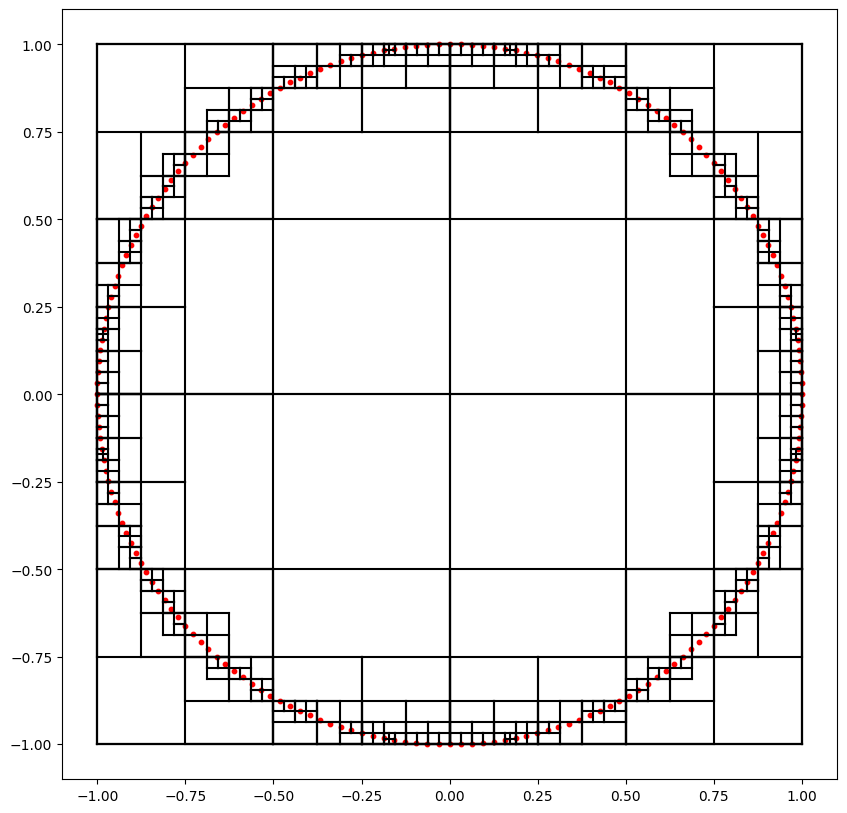

In [152]:
import matplotlib.pyplot as plt

def plot_quadtree(node, ax):
    """ Función recursiva para dibujar los límites del quadtree. """
    xmin, ymin, xmax, ymax = node.bounds
    ax.plot([xmin, xmax], [ymin, ymin], 'k-')
    ax.plot([xmin, xmax], [ymax, ymax], 'k-')
    ax.plot([xmin, xmin], [ymin, ymax], 'k-')
    ax.plot([xmax, xmax], [ymin, ymax], 'k-')

    for child in node.children:
        plot_quadtree(child, ax)

# Visualizar el quadtree
fig, ax = plt.subplots(figsize=(10,10))
plot_quadtree(quadtree, ax)
ax.scatter(boundary_points[:, 0], boundary_points[:, 1], color='red', s=10)  # Dibujar los puntos de la frontera
plt.show()
